# Automatic Differentiation
:label:`sec_autograd`

Recall from :numref:`sec_calculus` 
that calculating derivatives is the crucial step
in all the optimization algorithms
that we will use to train deep networks.
While the calculations are straightforward,
working them out by hand can be tedious and error-prone, 
and these issues only grow
as our models become more complex.

Fortunately all modern deep learning frameworks
take this work off our plates
by offering *automatic differentiation*
(often shortened to *autograd*). 
As we pass data through each successive function,
the framework builds a *computational graph* 
that tracks how each value depends on others.
To calculate derivatives, 
automatic differentiation 
works backwards through this graph
applying the chain rule. 
The computational algorithm for applying the chain rule
in this fashion is called *backpropagation*.

While autograd libraries have become
a hot concern over the past decade,
they have a long history. 
In fact the earliest references to autograd
date back over half of a century :cite:`Wengert.1964`.
The core ideas behind modern backpropagation
date to a PhD thesis from 1980 :cite:`Speelpenning.1980`
and were further developed in the late 1980s :cite:`Griewank.1989`.
While backpropagation has become the default method 
for computing gradients, it is not the only option. 
For instance, the Julia programming language employs 
forward propagation :cite:`Revels.Lubin.Papamarkou.2016`. 
Before exploring methods, 
let's first master the autograd package.


In [21]:
import torch

## A Simple Function

Let's assume that we are interested
in (**differentiating the function
$y = 2\mathbf{x}^{\top}\mathbf{x}$
with respect to the column vector $\mathbf{x}$.**)
To start, we assign `x` an initial value.


In [22]:
x = torch.arange(4.0)
x

tensor([0., 1., 2., 3.])

[**Before we calculate the gradient
of $y$ with respect to $\mathbf{x}$,
we need a place to store it.**]
In general, we avoid allocating new memory
every time we take a derivative 
because deep learning requires 
successively computing derivatives
with respect to the same parameters
a great many times,
and we might risk running out of memory.
Note that the gradient of a scalar-valued function
with respect to a vector $\mathbf{x}$
is vector-valued with 
the same shape as $\mathbf{x}$.


In [23]:
# Can also create x = torch.arange(4.0, requires_grad=True)
x.requires_grad_(True)
x.grad  # The gradient is None by default

(**We now calculate our function of `x` and assign the result to `y`.**)


In [24]:
y = 2 * torch.dot(x, x)
y

tensor(28., grad_fn=<MulBackward0>)

[**We can now take the gradient of `y`
with respect to `x`**] by calling 
its `backward` method.
Next, we can access the gradient 
via `x`'s `grad` attribute.


In [25]:
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

(**We already know that the gradient of the function $y = 2\mathbf{x}^{\top}\mathbf{x}$
with respect to $\mathbf{x}$ should be $4\mathbf{x}$.**)
We can now verify that the automatic gradient computation
and the expected result are identical.


In [26]:
x.grad == 4 * x

tensor([True, True, True, True])

[**Now let's calculate 
another function of `x`
and take its gradient.**]
Note that PyTorch does not automatically 
reset the gradient buffer 
when we record a new gradient. 
Instead, the new gradient
is added to the already-stored gradient.
This behavior comes in handy
when we want to optimize the sum 
of multiple objective functions.
To reset the gradient buffer,
we can call `x.grad.zero_()` as follows:


In [27]:
x.grad.zero_()  # Reset the gradient
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

## Backward for Non-Scalar Variables

When `y` is a vector, 
the most natural representation 
of the derivative of  `y`
with respect to a vector `x` 
is a matrix called the *Jacobian*
that contains the partial derivatives
of each component of `y` 
with respect to each component of `x`.
Likewise, for higher-order `y` and `x`,
the result of differentiation could be an even higher-order tensor.

While Jacobians do show up in some
advanced machine learning techniques,
more commonly we want to sum up 
the gradients of each component of `y`
with respect to the full vector `x`,
yielding a vector of the same shape as `x`.
For example, we often have a vector 
representing the value of our loss function
calculated separately for each example among
a *batch* of training examples.
Here, we just want to (**sum up the gradients
computed individually for each example**).


Because deep learning frameworks vary 
in how they interpret gradients of
non-scalar tensors,
PyTorch takes some steps to avoid confusion.
Invoking `backward` on a non-scalar elicits an error 
unless we tell PyTorch how to reduce the object to a scalar. 
More formally, we need to provide some vector $\mathbf{v}$ 
such that `backward` will compute 
$\mathbf{v}^\top \partial_{\mathbf{x}} \mathbf{y}$ 
rather than $\partial_{\mathbf{x}} \mathbf{y}$. 
This next part may be confusing,
but for reasons that will become clear later, 
this argument (representing $\mathbf{v}$) is named `gradient`. 
For a more detailed description, see Yang Zhang's 
[Medium post](https://zhang-yang.medium.com/the-gradient-argument-in-pytorchs-backward-function-explained-by-examples-68f266950c29).


In [28]:
x.grad.zero_()
y = x * x
y.backward(gradient=torch.ones(len(y)))  # Faster: y.sum().backward()
x.grad

tensor([0., 2., 4., 6.])

## Detaching Computation

Sometimes, we wish to [**move some calculations
outside of the recorded computational graph.**]
For example, say that we use the input 
to create some auxiliary intermediate terms 
for which we do not want to compute a gradient. 
In this case, we need to *detach* 
the respective computational graph
from the final result. 
The following toy example makes this clearer: 
suppose we have `z = x * y` and `y = x * x` 
but we want to focus on the *direct* influence of `x` on `z` 
rather than the influence conveyed via `y`. 
In this case, we can create a new variable `u`
that takes the same value as `y` 
but whose *provenance* (how it was created)
has been wiped out.
Thus `u` has no ancestors in the graph
and gradients do not flow through `u` to `x`.
For example, taking the gradient of `z = x * u`
will yield the result `u`,
(not `3 * x * x` as you might have 
expected since `z = x * x * x`).


In [29]:
x.grad.zero_()
y = x * x
u = y.detach()
z = u * x

z.sum().backward()
x.grad == u

tensor([True, True, True, True])

Note that while this procedure
detaches `y`'s ancestors
from the graph leading to `z`, 
the computational graph leading to `y` 
persists and thus we can calculate
the gradient of `y` with respect to `x`.


In [30]:
x.grad.zero_()
y.sum().backward()
x.grad == 2 * x

tensor([True, True, True, True])

## Gradients and Python Control Flow

So far we reviewed cases where the path from input to output 
was well defined via a function such as `z = x * x * x`.
Programming offers us a lot more freedom in how we compute results. 
For instance, we can make them depend on auxiliary variables 
or condition choices on intermediate results. 
One benefit of using automatic differentiation
is that [**even if**] building the computational graph of 
(**a function required passing through a maze of Python control flow**)
(e.g., conditionals, loops, and arbitrary function calls),
(**we can still calculate the gradient of the resulting variable.**)
To illustrate this, consider the following code snippet where 
the number of iterations of the `while` loop
and the evaluation of the `if` statement
both depend on the value of the input `a`.


In [31]:
def f(a):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

Below, we call this function, passing in a random value, as input.
Since the input is a random variable, 
we do not know what form 
the computational graph will take.
However, whenever we execute `f(a)` 
on a specific input, we realize 
a specific computational graph
and can subsequently run `backward`.


In [48]:
a = torch.randn(size=(), requires_grad=True)
# a = torch.tensor([1.0,2.0,3.0],requires_grad=True)
# a = torch.tensor([[1.0,2.0],[1.3,2.3]],requires_grad=True)
print(a)
d = f(a)
print(d)
# d.backward()

tensor(1.4008, requires_grad=True)
tensor(1434.4608, grad_fn=<MulBackward0>)


Even though our function `f` is, for demonstration purposes, a bit contrived,
its dependence on the input is quite simple: 
it is a *linear* function of `a` 
with piecewise defined scale. 
As such, `f(a) / a` is a vector of constant entries 
and, moreover, `f(a) / a` needs to match 
the gradient of `f(a)` with respect to `a`.


In [33]:
a.grad == d / a

tensor(True)

tensor(-0.1744, requires_grad=True)
tensor(-0.1744, requires_grad=True) tensor(-0.1735, grad_fn=<SinBackward0>) tensor(0.9848, grad_fn=<CosBackward0>) tensor(0.9848) tensor(0.1735)


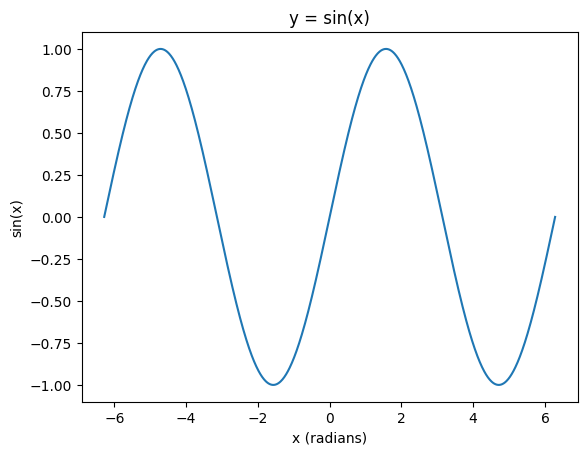

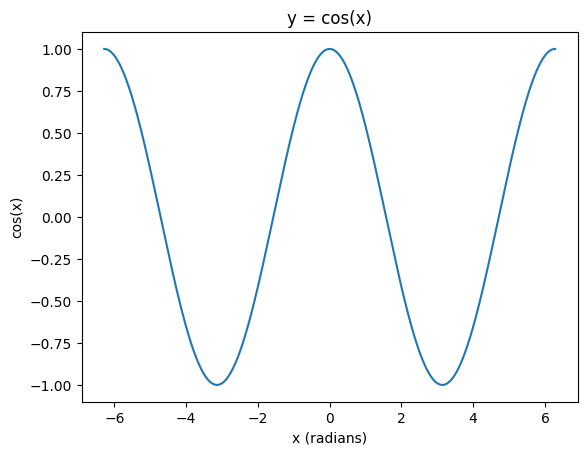

In [73]:
# for Q4 in Exercise
x = torch.randn(size=(),requires_grad=True)
print(x)
sin_x=torch.sin(x)
sin_x.backward()
grad_sin_x=x.grad.clone()
x.grad.zero_()
cos_x=torch.cos(x)
cos_x.backward()
grad_cos_x=x.grad.clone()
print(x, sin_x, cos_x, grad_sin_x,grad_cos_x)
import numpy as np
import matplotlib.pyplot as plt

# define the domain
x = np.linspace(-2*np.pi, 2*np.pi, 1000)

# evaluate the function
y = np.sin(x)

# plot
plt.plot(x, y)
plt.xlabel("x (radians)")
plt.ylabel("sin(x)")
plt.title("y = sin(x)")
plt.show()

# define the domain
x = np.linspace(-2*np.pi, 2*np.pi, 1000)

# evaluate the function
y = np.cos(x)

# plot
plt.plot(x, y)
plt.xlabel("x (radians)")
plt.ylabel("cos(x)")
plt.title("y = cos(x)")
plt.show()


Dynamic control flow is very common in deep learning. 
For instance, when processing text, the computational graph
depends on the length of the input. 
In these cases, automatic differentiation 
becomes vital for statistical modeling 
since it is impossible to compute the gradient *a priori*. 

## Discussion

You have now gotten a taste of the power of automatic differentiation. 
The development of libraries for calculating derivatives
both automatically and efficiently 
has been a massive productivity booster
for deep learning practitioners,
liberating them so they can focus on less menial.
Moreover, autograd lets us design massive models
for which pen and paper gradient computations 
would be prohibitively time consuming.
Interestingly, while we use autograd to *optimize* models
(in a statistical sense)
the *optimization* of autograd libraries themselves
(in a computational sense)
is a rich subject
of vital interest to framework designers.
Here, tools from compilers and graph manipulation 
are leveraged to compute results 
in the most expedient and memory-efficient manner. 

For now, try to remember these basics: **(i) attach gradients to those variables with respect to which we desire derivatives; (ii) record the computation of the target value; (iii) execute the backpropagation function; and  (iv) access the resulting gradient.**


## Exercises

1. Why is the second derivative much more expensive to compute than the first derivative?
1. After running the function for backpropagation, immediately run it again and see what happens. Investigate.
1. In the control flow example where we calculate the derivative of `d` with respect to `a`, what would happen if we changed the variable `a` to a random vector or a matrix? At this point, the result of the calculation `f(a)` is no longer a scalar. What happens to the result? How do we analyze this?
1. Let $f(x) = \sin(x)$. Plot the graph of $f$ and of its derivative $f'$. Do not exploit the fact that $f'(x) = \cos(x)$ but rather use automatic differentiation to get the result. 
1. Let $f(x) = ((\log x^2) \cdot \sin x) + x^{-1}$. Write out a dependency graph tracing results from $x$ to $f(x)$. 
1. Use the chain rule to compute the derivative $\frac{df}{dx}$ of the aforementioned function, placing each term on the dependency graph that you constructed previously. 
1. Given the graph and the intermediate derivative results, you have a number of options when computing the gradient. Evaluate the result once starting from $x$ to $f$ and once from $f$ tracing back to $x$. The path from $x$ to $f$ is commonly known as *forward differentiation*, whereas the path from $f$ to $x$ is known as backward differentiation. 
1. When might you want to use forward, and when backward, differentiation? Hint: consider the amount of intermediate data needed, the ability to parallelize steps, and the size of matrices and vectors involved.


## Answers for Exercices


1. Second derivatives have to be computed on top of the first, and when calculating the second derivatives, the compuater need to store the result of the first derivatives.
2. It will cause an runtime error :"RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward." As the values for computing the graph  is freed so the computing graph can not be recovered during the second run without specifing retain_graph=True.
3. The change of a to vector/matrix will raise an RuntimeError: "grad can be implicitly created only for scalar outputs" when calculating grad. The resulting f(a) will be a vector or matrix of the same shape of scalar a after the changes.
4. the graph of f will be an sin wave function, and its derivative $f'$ would be $f'(x)=\cos(x)$ with a cosine wave function. (Details of Q4 are attached)
5. A mental DAG for $f(x)$ has 9 nodes, node 1 is $x$, node 2 is $x^2$, node 3 is $\log x^2$, node 4 is $x$, node 5 is $sin(x)$, node 6 is $((\log x^2) \cdot \sin(x))$, node 7 id $x$, node 8 is $x^{-1}$, node 9 is $f(x) = ((\log x^2) \cdot \sin x) + x^{-1}$, with the directions of the arrow pointing from 1 to 2, 2 to 3 3 to 6, 4 to 5, 5 to 6, 7 to 8, 8 to 9, 6 to 9.
6. node 9: $f'(x) = g(k)+h(x)$, where $h'(x)= \frac {1}{x} $, node 8 is $h(x)= \frac {1}{x}$, node 7 is no longer needed, node 6 is $g(k)=p(b)\cdot q(x)$, where $k=p(b)\cdot q(x)$, $g'(k)=p'(b) \cdot q(x) + p(b) \cdot q'(x)$, since node 5 computes $q'(x)=cos(x)$ and $q(x)=sin(x)$, node 4 is no longer needed, node 3 is returns $p(b)= \log x^2 $, node 2 returns $b=x^2$, $b'(x)=2x$ and $p'(b)= \log b$, so $p(x)=p'(b) \cdot b'(x)= \frac {1}{x^2} \cdot 2x = \frac{2}{x}$, node 1 is no longer needed, in summary, node 9 is $\frac{2}{x} \cdot sin(x) + \log {x^2} \cdot cos(x) + \frac{1}{x}$
7. The above answer for question 6 showed the backgward differentiation, where x is fully exposed only at the end of differentiation, in forward differentiation, it would start with x and use other variables to represent compositions of x in a increasingly complex manner.
8. In model training with large set of parameters and variables, it is better to use backward differentiation as it is more reasonable with the usage of parallelized cores, as nodes merges in the higher order nodes, so if you start from top order layer, a more complex differention process can run longer in the core as it is more guranteed to have occupied a dedicated core earlier. But if you start with lower layers, some up the input may not be included or important in the higher layer or the result, it can cause a waste of computational resources. But if you want clear and more easy to understand differention logic or you want to run the graph once for the first time for the random value to start, forward differention maybe suitable. 

Below is a **grading + correction** of each of the above 8 answers, followed by a **fully corrected & rigorous version** (with “ mistake / common confusions” notes).

 **AD = Automatic Differentiation**, **DAG = Directed Acyclic Graph**, **VJP = Vector–Jacobian Product**, **JVP = Jacobian–Vector Product** (expanded once, then abbreviated).

---

## 1) Grading + corrections (your current answers)

### Q1. Why is the second derivative much more expensive than the first?

**Grade: 6/10 (partly correct but incomplete).**
You said: “second derivatives computed on top of first; need to store first-derivative results.” That’s not the main reason, and it’s not generally phrased right.

**What’s really going on**

* Computing *first derivatives* via backprop is roughly a small constant multiple of the forward cost.
* Computing *second derivatives* often requires **differentiating the backward pass itself**, which introduces:

  * **extra graph construction** (you must keep/create a graph for gradients),
  * **much more intermediate state** (need saved tensors from forward + backward),
  * **higher computational complexity**: Hessians scale like (n^2) entries for (n) parameters if you try to form them explicitly.
* Also: a “second derivative” can mean many things (full Hessian vs Hessian-vector product). The *full Hessian* is especially expensive.

**Your key missing point:** **dimensional blow-up** (Hessian is huge) and **you must retain/build a graph for gradients**.

---

### Q2. Run backprop twice immediately—what happens?

**Grade: 9/10 (correct).**
Your explanation matches PyTorch behavior: after `.backward()`, by default the graph is freed; a second `.backward()` through the same graph errors unless `retain_graph=True` (or you recompute the forward).

**Minor nuance to add**

* You *can* run backward again if you **recompute the forward** (build a new graph).
* Or if you need higher-order derivatives, you typically use `create_graph=True` (in `torch.autograd.grad`) or `retain_graph=True` depending on goal.

---

### Q3. If `a` becomes vector/matrix so `f(a)` not scalar, what happens?

**Grade: 7/10 (mostly correct, but missing the right analysis).**
You correctly noted the common error: *“grad can be implicitly created only for scalar outputs”* when calling `.backward()` without specifying a gradient.

**What you should add**

* If output is non-scalar (y=f(a)), then “the derivative” is the **Jacobian** (J=\frac{\partial y}{\partial a}), not a single gradient vector.
* PyTorch’s `.backward()` computes **VJP (Vector–Jacobian Product)**: given an upstream vector (v) with same shape as (y), it computes (J^\top v).
* So you can do:

  * `y.backward(torch.ones_like(y))` to get the gradient of (\sum_i y_i),
  * or `torch.autograd.grad(y, a, grad_outputs=v)` for any chosen (v).

**Your key missing point:** explain that PyTorch returns **a VJP**, not a full Jacobian.

---

### Q4. Plot (f(x)=\sin x) and (f'(x)) using AD (don’t use (\cos x) fact)

**Grade: 5/10 (conceptually right, but your implementation doesn’t satisfy the exercise).**

Problems in your current approach:

1. You used `x = torch.randn(size=(), ...)` which is a **single scalar**. To *plot*, you need many x-values.
2. You computed `cos_x = torch.cos(x)` explicitly. The exercise says: do **not** exploit (f'(x)=\cos x). You should compute the derivative via AD.
3. Your plots use NumPy’s `np.sin` and `np.cos`, not AD-derived derivatives.

**What you should do instead**

* Make a tensor of x-values: `x = torch.linspace(...)` with `requires_grad=True`.
* Compute `y = torch.sin(x)`.
* To get `dy/dx` for a vector output, supply `grad_outputs=torch.ones_like(y)` (VJP gives elementwise derivative because the function is elementwise).

---

### Q5. Dependency graph (DAG) for (f(x)= (\log x^2)\sin x + x^{-1})

**Grade: 8/10 (basically correct).**
Your node listing is mostly fine. A small improvement:

* Don’t duplicate `x` as separate nodes unless you’re emphasizing “fan-out”; in a DAG, one `x` node can feed multiple ops.
* Also note domain constraints: (\log(x^2)) is fine for (x\neq 0); (x^{-1}) also requires (x\neq 0).

---

### Q6. Use chain rule to compute (df/dx) and place terms on the graph

**Grade: 4/10 (multiple math mistakes).**
Main issues:

1. Derivative of (x^{-1}):
   [
   \frac{d}{dx}x^{-1} = -x^{-2} = -\frac{1}{x^2}
   ]
   You wrote (+1/x) (wrong).
2. Derivative of (\log(x^2)):
   [
   \frac{d}{dx}\log(x^2)=\frac{2}{x}\quad (x\neq 0)
   ]
   You tried to route through (b=x^2) but then wrote **(p'(b)=\log b)** (wrong). It should be (p'(b)=1/b).
3. Product rule term signs and components: your final expression is not consistent.

Correct final derivative is:
[
f'(x)=\frac{2}{x}\sin x+\log(x^2)\cos x-\frac{1}{x^2},\quad x\neq 0
]

---

### Q7. Forward vs backward differentiation description

**Grade: 6/10 (idea okay, but too vague / slightly inaccurate).**
Your statement “Q6 showed backward differentiation” is not really true—you just did symbolic differentiation and some chain rule bookkeeping. Forward/backward AD are *algorithms* for propagating derivatives, not just “whether x is exposed at the end.”

You should describe:

* **Forward mode (JVP):** propagate derivative info from inputs → outputs.
* **Reverse mode (VJP / backprop):** propagate sensitivities from outputs → inputs.

---

### Q8. When to use forward vs backward differentiation

**Grade: 4/10 (mostly incorrect reasoning).**
The core rule is about **input dimension vs output dimension**, plus memory.

* Forward mode (JVP) is good when **#inputs is small** and **#outputs is large** (e.g., many outputs, few parameters).
* Reverse mode (VJP / backprop) is good when **#outputs is small** (often scalar loss) and **#inputs is large** (millions of parameters)—this is why deep learning uses backprop.

Parallelization arguments you gave are not the main deciding factor and some parts don’t really make sense (e.g., “higher layers occupy a dedicated core earlier”).

---

## 2) Fully corrected & rigorous version (with reminders)

You can paste this as a clean study note.

---

### Q1. Why is the second derivative much more expensive than the first derivative?

**Answer (rigorous):**
Let (f:\mathbb{R}^n\to\mathbb{R}). The first derivative is the gradient (\nabla f(x)\in\mathbb{R}^n). The second derivative is the Hessian (H(x)=\nabla^2 f(x)\in\mathbb{R}^{n\times n}). Computing/storing the full Hessian scales like (O(n^2)) entries, which is already much larger than the (O(n)) gradient. Moreover, in AD frameworks, computing second derivatives typically requires differentiating through the backward pass, which means:

* keeping more intermediate tensors (often you must **retain/build a graph for gradients**),
* performing additional passes with similar cost to backprop,
* potentially constructing very large computational graphs.

**Your mistake / common confusion:**

* It’s not mainly “because you store first derivatives.” The big reasons are **Hessian size** and **differentiating the backward computation** (extra graph + memory + compute).

---

### Q2. Run backprop twice immediately—what happens?

**Answer (rigorous):**
In PyTorch, after you call `y.backward()` (or `torch.autograd.grad` without `retain_graph=True`), the saved intermediate tensors for that computation graph are freed to save memory. If you call backward again on the **same graph**, PyTorch raises:

> Trying to backward through the graph a second time…

To backprop twice you can:

1. **Recompute** the forward pass to build a fresh graph, then call backward again, or
2. Use `retain_graph=True` on the first backward call if you truly need the same graph again.

**Your mistake / common confusion:**

* Your answer is correct. Just remember: “run again” works if you recompute forward (new graph).

---

### Q3. If (a) is a vector/matrix and (f(a)) is not scalar, what happens?

**Answer (rigorous):**
If (y=f(a)) is not scalar, then the derivative is the **Jacobian**:
[
J=\frac{\partial y}{\partial a}.
]
PyTorch’s `.backward()` does not automatically form (J). Instead, it computes a **VJP (Vector–Jacobian Product)**. You must provide an upstream tensor (v) with the same shape as (y), and PyTorch computes:
[
\frac{\partial}{\partial a}\langle v, y\rangle ;=; J^\top v.
]
That’s why calling `y.backward()` without `v` errors: it doesn’t know which linear combination of outputs you want.

**How to handle it:**

* If you want the gradient of (\sum_i y_i), use `y.backward(torch.ones_like(y))`.
* For a specific weighting (v), use `y.backward(v)` or `torch.autograd.grad(y, a, grad_outputs=v)`.

**Your mistake / common confusion:**

* You stopped at the runtime error. The analysis answer is: “non-scalar output ⇒ Jacobian; PyTorch computes VJP given `grad_outputs`.”

---

### Q4. Plot (f(x)=\sin x) and its derivative using AD (without using (\cos x))

**Answer (rigorous + correct AD approach):**
To plot, use a vector of x-values. Let (x\in\mathbb{R}^m) with `requires_grad=True`. Then (y=\sin(x)) is also length (m). The elementwise derivative is (dy_i/dx_i), and PyTorch can produce it via a VJP by summing outputs:
[
\frac{\partial}{\partial x}\sum_{i=1}^m y_i
]
which yields exactly the elementwise derivative because each (y_i) depends only on (x_i).

**Correct code (minimal, AD-derived derivative):**

```python
import torch
import matplotlib.pyplot as plt
import numpy as np

# x as a vector so we can plot
x = torch.linspace(-2*np.pi, 2*np.pi, 1000, requires_grad=True)

y = torch.sin(x)

# VJP with ones = gradient of sum(y), equals elementwise dy/dx here
y.backward(torch.ones_like(y))
dy_dx = x.grad

# plot using detached tensors
plt.plot(x.detach().numpy(), y.detach().numpy(), label="sin(x)")
plt.plot(x.detach().numpy(), dy_dx.detach().numpy(), label="d/dx sin(x) (autograd)")
plt.xlabel("x")
plt.legend()
plt.show()
```

**Your mistake / common confusion:**

* Using a single scalar `x` cannot produce a curve.
* Plotting `np.cos(x)` violates the “don’t use the known derivative” instruction.
* When output is a vector, you must supply `grad_outputs` (here: ones) to get gradients.

---

### Q5. Dependency graph (DAG) for (f(x) = (\log x^2)\sin x + x^{-1})

**Answer (rigorous DAG):**
Define intermediates:

* (u = x^2)
* (v = \log(u))
* (w = \sin(x))
* (t = v\cdot w)
* (s = x^{-1})
* (f = t + s)

Edges:

* (x \to u \to v \to t \to f)
* (x \to w \to t)
* (x \to s \to f)

**Domain note:** (x\neq 0) (because of (x^{-1}); (\log(x^2)) is fine for (x\neq 0) too).

**Your mistake / common confusion:**

* Your structure is fine; just avoid duplicating (x) nodes unless you’re explicitly illustrating fan-out.

---

### Q6. Compute (df/dx) using chain rule, place terms on the graph

**Answer (rigorous):**
From the DAG:

1. (u=x^2 \Rightarrow \frac{du}{dx}=2x)

2. (v=\log(u) \Rightarrow \frac{dv}{du}=\frac{1}{u}) so
   [
   \frac{dv}{dx}=\frac{dv}{du}\frac{du}{dx}=\frac{1}{x^2}\cdot 2x=\frac{2}{x}\quad (x\neq 0)
   ]

3. (w=\sin x \Rightarrow \frac{dw}{dx}=\cos x)

4. (t=v\cdot w \Rightarrow \frac{dt}{dx}= \frac{dv}{dx}w + v\frac{dw}{dx})
   [
   \frac{dt}{dx}=\frac{2}{x}\sin x + \log(x^2)\cos x
   ]

5. (s=x^{-1} \Rightarrow \frac{ds}{dx}=-x^{-2}=-\frac{1}{x^2})

6. (f=t+s\Rightarrow f' = t' + s')

Final:
[
\boxed{f'(x)=\frac{2}{x}\sin x+\log(x^2)\cos x-\frac{1}{x^2}},\quad x\neq 0
]

**Your mistake / common confusion:**

* (d(x^{-1})/dx) is **negative**.
* (d(\log u)/du = 1/u), not (\log u).
* Keep the chain rule in the form “local derivative × upstream derivative” to avoid mixing layers.

---

### Q7. Forward vs backward differentiation on this graph

**Answer (rigorous):**

* **Forward differentiation (forward-mode AD, JVP):** propagate derivatives from (x) forward through each node. You compute each intermediate’s derivative w.r.t. (x): (\frac{du}{dx}, \frac{dv}{dx}, \frac{dw}{dx}, \frac{dt}{dx}, \frac{ds}{dx}, \frac{df}{dx}).
* **Backward differentiation (reverse-mode AD, VJP / backprop):** propagate sensitivities backward from output. You compute adjoints like (\bar{v}=\frac{\partial f}{\partial v}), (\bar{w}=\frac{\partial f}{\partial w}), then back to (x).

**Your mistake / common confusion:**

* It’s not about “x only exposed at the end.” It’s about whether you propagate **derivative information forward (JVP)** or **sensitivity backward (VJP)**.

---

### Q8. When to use forward vs backward differentiation?

**Answer (rigorous rule-of-thumb):**
Let (f:\mathbb{R}^n\to\mathbb{R}^m).

* **Forward mode (JVP)** is efficient when **(n) is small** and (m) is large.
  Cost scales roughly with the number of input directions you need (often (\propto n)).

* **Reverse mode (VJP / backprop)** is efficient when **(m) is small** (especially (m=1), a scalar loss) and (n) is large.
  This is deep learning’s usual case: (f) is the scalar loss, (n) is millions of parameters.

**Memory tradeoff:**
Reverse mode typically stores more intermediate activations from the forward pass (or recomputes them), while forward mode can be lighter per direction but becomes expensive if you need many input directions.

**Your mistake / common confusion:**

* The key deciding factor is **input vs output dimension**, not “core occupancy” or “higher layers run longer.” Parallelization exists in both modes; the dominant reason deep nets use backprop is **scalar loss + huge parameter count**.

---

If you want, paste the *exact D2L control-flow example code* you used for Q3 (the `d` w.r.t. `a` one). I can tell you precisely what PyTorch will compute (shape-by-shape) when you switch `a` from scalar → vector → matrix, and how to choose `grad_outputs` to interpret the result cleanly.


[Discussions](https://discuss.d2l.ai/t/35)
